In [112]:
# TODO: manage imports
library(eurostat)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(repr)
library(vtable)
library(tidyr)
library(tibble)

Loading required package: grid



In [12]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1
data.frame(
  country=c('ČR', 'Norsko', 'Rakousko', 'Belgie', 'Řecko', 'Španělsko', 
            'Nizozemsko', 'Portugalsko', 'Švýcarsko	', 'Finsko', 'Irsko'),
  examiner=c(rep('K. Dedecius', 6), rep('P. Novák', 5))
)[M,]

,country,examiner
,<chr>,<chr>
2,Norsko,K. Dedecius


In [13]:
dataset <- get_eurostat(id ='crim_gen_reg')

Dataset query already saved in cache_list.json...

Reading cache file /tmp/Rtmp46bToz/eurostat/a2939e209a7e6021da51fe52fa89a065.rds

Table  crim_gen_reg  read from cache file:  /tmp/Rtmp46bToz/eurostat/a2939e209a7e6021da51fe52fa89a065.rds



In [14]:
str(dataset)

tibble [216,947 × 6] (S3: tbl_df/tbl/data.frame)
 $ freq       : chr [1:216947] "A" "A" "A" "A" ...
 $ unit       : chr [1:216947] "NR" "NR" "NR" "NR" ...
 $ iccs       : chr [1:216947] "ICCS0101" "ICCS0101" "ICCS0101" "ICCS0101" ...
 $ geo        : chr [1:216947] "AL" "AL" "AL" "AL" ...
 $ TIME_PERIOD: Date[1:216947], format: "2008-01-01" "2009-01-01" ...
 $ values     : num [1:216947] 88 82 118 124 126 107 98 54 71 52 ...


In [15]:
unique(dataset$TIME_PERIOD)

[1] "2008-01-01" "2009-01-01" "2010-01-01" "2011-01-01" "2012-01-01"
 [6] "2013-01-01" "2014-01-01" "2015-01-01" "2016-01-01" "2017-01-01"
[11] "2018-01-01" "2019-01-01" "2020-01-01" "2021-01-01"

In [16]:
data <- subset(dataset, 
    startsWith(geo, 'NO') &
    nchar(geo) == 5 &
    TIME_PERIOD == '2021-01-01'
)
data$TIME_PERIOD <- NULL
data$freq <- NULL

prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Theft', 'Theft of a m. l. vehicle')
data$iccs <- factor(data$iccs, levels=prev_labels, labels=new_labels)

In [17]:
data_by_unit <- split(data[,-1], data$unit)
all.equal(data_by_unit$P_HTHAB[,1:2], data_by_unit$NR[,1:2])

[1] TRUE

In [18]:
data <- merge(x=data_by_unit$P_HTHAB, y=data_by_unit$NR, by=c('iccs', 'geo'), all=TRUE)  # outer join
colnames(data)[3] <- 'rel'
colnames(data)[4] <- 'abs'

In [19]:
any(is.na(data))

[1] FALSE

In [96]:
freq_table <- pivot_wider(data[, -4], names_from=iccs, values_from=rel) %>%
    column_to_rownames('geo') %>%
    as.matrix() %>%
    as.table()
names(dimnames(freq_table)) <- c('geo', 'iccs')

In [117]:
freq_table

       iccs
geo     Int. homicide Robbery   Theft Theft of a m. l. vehicle
  NO020          0.00    5.13  821.90                    32.92
  NO060          0.21    8.91 1382.86                    62.40
  NO071          0.00    1.66  620.36                    37.03
  NO074          0.00    5.78  775.49                    43.77
  NO081          1.00   46.91 3017.17                    74.32
  NO082          1.04   10.46 1294.65                    54.62
  NO091          0.47   10.43 1451.83                    91.97
  NO092          0.32   12.95 1793.14                   112.35
  NO0A1          0.00   11.40 1444.75                    55.53
  NO0A2          0.47    7.83 1135.84                    32.09
  NO0A3          0.75    2.64  595.00                    25.23

In [99]:
prob_table.row_cond <- prop.table(freq_table, margin=1)
prob_table.col_cond <- prop.table(freq_table, margin=2)

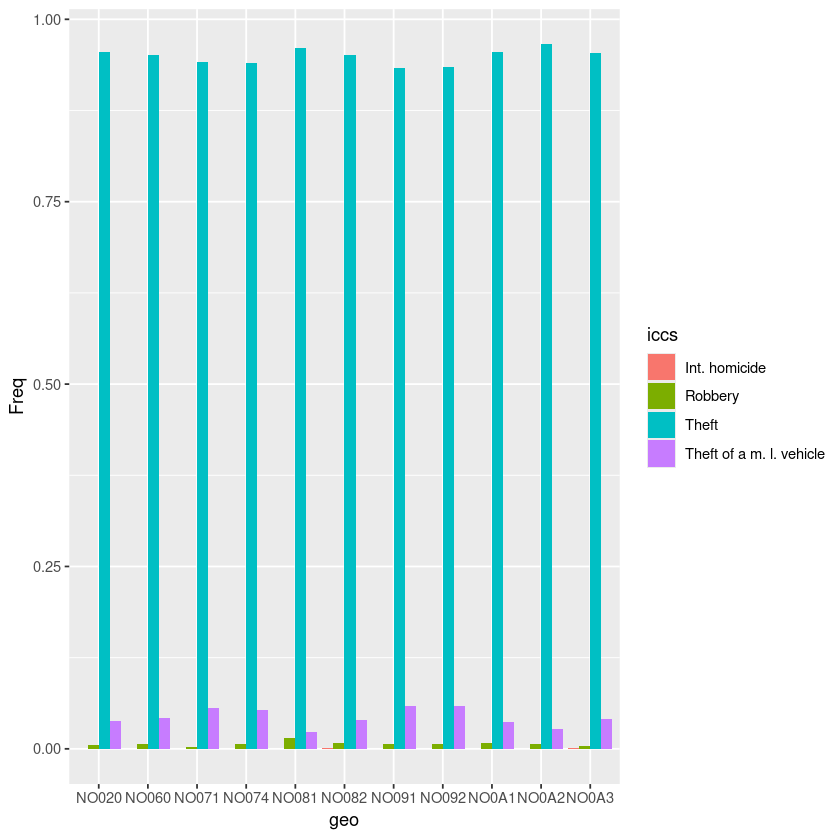

In [103]:
# TODO: rename axes
ggplot(as.data.frame(prob_table.row_cond), aes(x=geo, y=Freq, fill=iccs)) +
  geom_bar(stat='identity', position='dodge')

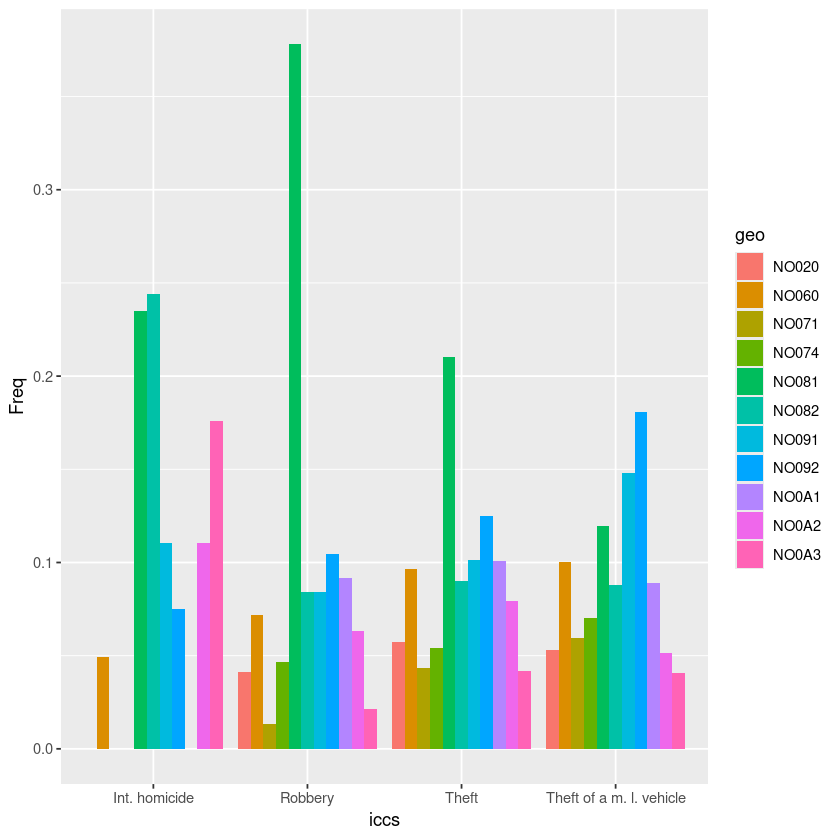

In [107]:
# TODO: rename axes
ggplot(as.data.frame(prob_table.col_cond), aes(x=iccs, y=Freq, fill=geo)) +
    geom_bar(stat='identity', position='dodge')